In [ ]:
EXPNUM = '005'

In [ ]:
!git clone --single-branch https://github.com/poleval/2021-quality-estimation-nonblind -b main
!pip install datasets -qq
!pip install transformers -qq

Cloning into '2021-quality-estimation-nonblind'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 30 (delta 10), reused 26 (delta 6), pack-reused 0
Unpacking objects: 100% (30/30), done.
     |████████████████████████████████| 264 kB 5.0 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 118 kB 66.5 MB/s 
     |████████████████████████████████| 243 kB 58.0 MB/s 
     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 636 kB 50.9 MB/s 
     |████████████████████████████████| 895 kB 47.1 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn import model_selection
from datasets import Dataset
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
df1 = pd.read_csv('2021-quality-estimation-nonblind/dev-0/expected.tsv', sep='\t', header=None, names=['score'])
df2 = pd.read_csv('2021-quality-estimation-nonblind/dev-0/in.tsv', sep='\t', header=None, names=['t1', 't2', 't3'])
df3 = pd.read_csv('2021-quality-estimation-nonblind/test-A/expected.tsv', sep='\t', header=None, names=['score'])
df4 = pd.read_csv('2021-quality-estimation-nonblind/test-A/in.tsv', sep='\t', header=None, names=['t1', 't2', 't3'])
df5 = pd.concat([df2,df1], axis=1)
df6 = pd.concat([df4,df3], axis=1)
df = pd.concat([df5,df6], axis=0, ignore_index=True)
df

,t1,t2,t3,score
0,Zdjęcie satelitarne spoglądające na ziemię.,A satellite picture looking down at the earth.,Zdjęcie satelitarne Ziemii.,4.500000
1,Dlatego chcą zaistnieć jako potęga przemysłowa...,So they want to emerge as an industrial powerh...,Chcą przejawiać się jako siła napędzająca prze...,4.666667
2,I umieściłem je na moim zdjęciu.,And I put them into my photograph.,Umieściłam je na swoim zdjęciu.,4.583333
3,I znowu możesz myśleć o tym jak o prawie mapow...,And again you can think of this as almost mapp...,I znów można to traktować prawie jak mapowanie...,3.833333
4,Więc co jest najlepsze.,So what is the best.,Która metoda jest najlepsza?,4.416667
...,...,...,...,...
980,"Teraz pamiętaj, że ma iść do niebieskich kwiatów.",Now remember she is supposed to be going to th...,Teraz pamiętajcie że ona miała iść do niebies...,5.000000
981,Tak więc w drugiej wersji jest 100 miliardów l...,So in the second version of it there are 100 b...,Więc w drugiej wersji jest 100 miliardów czy 1...,4.500000
982,I nie zawsze ze sobą współpracują. Podoba mi s...,And they don not always work together I like F...,które nie zawsze współpracują. Lubię teorię Fr...,4.666667
983,"A jednak wciąż jest jeden na ciemnym tle, a dr...",And yet there is still one on a dark surround ...,Ale mimo wszystko jeden jest na ciemnym a drug...,4.583333


In [ ]:
tst = pd.read_csv('2021-quality-estimation-nonblind/test-B/in.tsv', sep='\t', header=None, names=['t1', 't2', 't3'])

In [ ]:
def print_high_low(df):
  h = df[df.score == df.score.max()].index[0]
  l = df[df.score == df.score.min()].index[0]

  rl = df.t3.loc[l]
  rh = df.t3.loc[h]
  tl = df.t1.loc[l]
  th = df.t1.loc[h]

  print(f'Worst translation:')
  print(f'Translation: {tl}')
  print(f'Reference: {rl}')
  print(f'Best tranlation:')
  print(f'Translation: {th}')
  print(f'Reference: {rh}')

print_high_low(df)

Worst translation:
Translation: Innej rzeczy można się nauczyć, podróżując do tych krajów na Bliskim Wschodzie, czasami do krajów Ameryki Łacińskiej. Kraje Ameryki Południowej.
Reference: Inna rzecz którą można zauważyć gdy podróżuje się po Bliskim Wschodzie czasem w Ameryce Łacińskiej Ameryce Południowej często kiedy budują robią to bez reguł i zasad.
Best tranlation:
Translation: Bum.
Reference: Bum!


In [ ]:
def create_folds(data, num_splits):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
        data["score"], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits, random_state=42)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data

In [ ]:
df = create_folds(df, num_splits=5)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
all_texts = pd.concat([df, tst], axis=0, ignore_index=True)
len(all_texts)

1985

In [ ]:
model_checkpoint = 'allegro/herbert-large-cased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
def ct_toks(row):
  t1 = row[0]
  t2 = row[1]
  t = t1 + ' ' + t2
  return len(tokenizer(t)['input_ids'])

all_texts['length'] = all_texts[['t1', 't3']].apply(ct_toks, axis=1)
all_texts.length.min(), all_texts.length.max()

(7, 205)

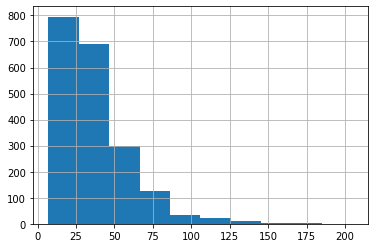

In [ ]:
all_texts['length'].hist()

In [ ]:
df = df.rename(columns={'score':'label'}) # HF expects this column name to pick up the target column in trainer

In [ ]:
val = df[df.kfold == 0].reset_index(drop=True)
val['pred'] = df[df.kfold != 0].label.mean()
mean_squared_error(val.label.values, val.pred.values, squared=False)

0.3797685384577315

In [ ]:
model_checkpoint, lr, bs, max_length, grad_acc, wd, schedule, epochs = ('allegro/herbert-large-cased', 2e-05, 8, 192, 1, 0.01, 'constant', 6)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

if 'RoBERTa' in model_checkpoint: 
  print('Adding pad token')
  tokenizer.pad_token = 0

if 'large' in model_checkpoint:
  init_layers = [23]
else:
  init_layers = [11]

def weights_init_custom(model):
  dense_names = ["query", "key", "value", "dense"]
  layernorm_names = ["LayerNorm"]
  prms = model.bert.named_parameters() if 'RoBERTa' not in model_checkpoint else model.roberta.named_parameters()
  for name, module in prms:
      if any(f".{i}." in name for i in init_layers):
          if any(n in name for n in dense_names):
              if "bias" in name:
                  module.data.zero_()
              elif "weight" in name:
                  module.data.normal_(mean=0.0, std=model.config.initializer_range)
          elif any(n in name for n in layernorm_names):
              if "bias" in name:
                  module.data.zero_()
              elif "weight" in name:
                  module.data.fill_(1.0)

def tokenize(batch): return tokenizer(batch['t1'], batch['t3'], padding='max_length', truncation=True, max_length=max_length)

In [ ]:
import torch.nn as nn

def compute_metrics(pred):
    return {
        'rmse': mean_squared_error(pred.label_ids, pred.predictions, squared=False),
    }

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1)
    weights_init_custom(model)
    model.dropout = nn.Dropout(p=0.0, inplace=False)
    paramg = model.bert.encoder.layer if 'RoBERTa' not in model_checkpoint else model.roberta.encoder.layer
    for l in paramg: 
      l.attention.self.dropout = nn.Dropout(p=0.0, inplace=False)
      l.attention.output.dropout = nn.Dropout(p=0.0, inplace=False)
      l.output.dropout = nn.Dropout(p=0.0, inplace=False)
    return model

def init_trainer(fold, seed):
    train_dataset = Dataset.from_pandas(df[df.kfold != fold].reset_index(drop=True))
    valid_dataset = Dataset.from_pandas(df[df.kfold == fold].reset_index(drop=True))
    train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
    valid_dataset = valid_dataset.map(tokenize, batched=True, batch_size=len(valid_dataset))
    args = TrainingArguments(
        "./tmp",
        evaluation_strategy = "steps",
        eval_steps=10,
        save_steps=10,
        save_total_limit=20,
        learning_rate=lr,
        fp16=False,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        gradient_accumulation_steps=grad_acc,
        lr_scheduler_type=schedule,
        num_train_epochs=epochs,
        seed=1,
        weight_decay=wd,
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model_init=model_init,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    return trainer

In [ ]:
preds = []
results = []

In [ ]:
test_df = tst.rename(columns={'score':'label'})
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
for fold in range(5):
    for seed in range(1):
        print('#' * 100)
        print(f'TRAINING FOLD {fold}')
        print('#' * 100)
        trainer = init_trainer(fold, seed)
        trainer.train()
        metrics = trainer.evaluate()
        results.append({
            'fold': fold,
            'seed': seed,
            'rmse': metrics['eval_rmse']
        })
        print('#' * 100)
        print(f'FOLD {fold} SCORE: {metrics["eval_rmse"]}')
        print('#' * 100)
        test_preds = trainer.predict(test_dataset)
        preds.append(test_preds[0])

####################################################################################################
TRAINING FOLD 0
####################################################################################################


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/allegro/herbert-large-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e512a74b9a525c868c0560254b3a65dc6309948f8cb99a8375429de673d28332.60289bb41d6aec457a093f9438a2c590beb41d64e7c830eac00dc56d3d49c5f6
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "posi

Step,Training Loss,Validation Loss,Rmse
10,No log,0.252317,0.502311
20,No log,0.128476,0.358435
30,No log,0.129490,0.359847
40,No log,0.113255,0.336534
50,No log,0.173371,0.416378
60,No log,0.117553,0.342860
70,No log,0.145360,0.381261
80,No log,0.121551,0.348642
90,No log,0.181939,0.426543
100,No log,0.115456,0.339788


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-10
Configuration saved in ./tmp/checkpoint-10/config.json
Model weights saved in ./tmp/checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./tmp/checkpoint-10/tokenizer_config.json
Special tokens file saved in ./tmp/checkpoint-10/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-20
Configuration saved in ./tmp/checkpoint-20/config.json
Model weights saved in ./tmp/checkpoint-20/pytorch_model.bin
tokenizer config file saved in ./tmp/checkpoint-20/tokeniz

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: t1, t3, t2.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


####################################################################################################
FOLD 0 SCORE: 0.3217563331127167
####################################################################################################
####################################################################################################
TRAINING FOLD 1
####################################################################################################


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/allegro/herbert-large-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e512a74b9a525c868c0560254b3a65dc6309948f8cb99a8375429de673d28332.60289bb41d6aec457a093f9438a2c590beb41d64e7c830eac00dc56d3d49c5f6
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_po

Step,Training Loss,Validation Loss,Rmse
10,No log,0.191112,0.437164
20,No log,0.142839,0.377940
30,No log,0.135059,0.367504
40,No log,0.157047,0.396292
50,No log,0.147140,0.383589
60,No log,0.152756,0.390840
70,No log,0.131573,0.362731
80,No log,0.103435,0.321613
90,No log,0.110469,0.332368
100,No log,0.114455,0.338313


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-10
Configuration saved in ./tmp/checkpoint-10/config.json
Model weights saved in ./tmp/checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./tmp/checkpoint-10/tokenizer_config.json
Special tokens file saved in ./tmp/checkpoint-10/special_tokens_map.json
Deleting older checkpoint [tmp/checkpoint-310] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-20
Configuration saved in ./tmp/checkpoint-20/config.json
Model weights saved in ./tmp/checkpoint-20/

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: t1, t3, t2.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


####################################################################################################
FOLD 1 SCORE: 0.30787310004234314
####################################################################################################
####################################################################################################
TRAINING FOLD 2
####################################################################################################


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/allegro/herbert-large-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e512a74b9a525c868c0560254b3a65dc6309948f8cb99a8375429de673d28332.60289bb41d6aec457a093f9438a2c590beb41d64e7c830eac00dc56d3d49c5f6
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_po

Step,Training Loss,Validation Loss,Rmse
10,No log,0.193161,0.439501
20,No log,0.151303,0.388977
30,No log,0.130335,0.361019
40,No log,0.112154,0.334895
50,No log,0.103676,0.321988
60,No log,0.107661,0.328118
70,No log,0.098992,0.314630
80,No log,0.095458,0.308962
90,No log,0.092479,0.304104
100,No log,0.091311,0.302178


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-10
Configuration saved in ./tmp/checkpoint-10/config.json
Model weights saved in ./tmp/checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./tmp/checkpoint-10/tokenizer_config.json
Special tokens file saved in ./tmp/checkpoint-10/special_tokens_map.json
Deleting older checkpoint [tmp/checkpoint-400] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-20
Configuration saved in ./tmp/checkpoint-20/config.json
Model weights saved in ./tmp/checkpoint-20/

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: t1, t3, t2.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


####################################################################################################
FOLD 2 SCORE: 0.2834027111530304
####################################################################################################
####################################################################################################
TRAINING FOLD 3
####################################################################################################


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/allegro/herbert-large-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e512a74b9a525c868c0560254b3a65dc6309948f8cb99a8375429de673d28332.60289bb41d6aec457a093f9438a2c590beb41d64e7c830eac00dc56d3d49c5f6
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_po

Step,Training Loss,Validation Loss,Rmse
10,No log,0.222673,0.471882
20,No log,0.185826,0.431075
30,No log,0.144534,0.380176
40,No log,0.139801,0.373900
50,No log,0.218972,0.467944
60,No log,0.175998,0.419521
70,No log,0.128056,0.357850
80,No log,0.172502,0.415333
90,No log,0.275705,0.525077
100,No log,0.124108,0.352290


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-10
Configuration saved in ./tmp/checkpoint-10/config.json
Model weights saved in ./tmp/checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./tmp/checkpoint-10/tokenizer_config.json
Special tokens file saved in ./tmp/checkpoint-10/special_tokens_map.json
Deleting older checkpoint [tmp/checkpoint-400] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-20
Configuration saved in ./tmp/checkpoint-20/config.json
Model weights saved in ./tmp/checkpoint-20/

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: t1, t3, t2.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


####################################################################################################
FOLD 3 SCORE: 0.31405699253082275
####################################################################################################
####################################################################################################
TRAINING FOLD 4
####################################################################################################


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/allegro/herbert-large-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e512a74b9a525c868c0560254b3a65dc6309948f8cb99a8375429de673d28332.60289bb41d6aec457a093f9438a2c590beb41d64e7c830eac00dc56d3d49c5f6
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_po

Step,Training Loss,Validation Loss,Rmse
10,No log,0.252013,0.502008
20,No log,0.122973,0.350675
30,No log,0.175666,0.419126
40,No log,0.119155,0.345188
50,No log,0.327034,0.571869
60,No log,0.133206,0.364973
70,No log,0.117895,0.343359
80,No log,0.118186,0.343782
90,No log,0.110969,0.333120
100,No log,0.155181,0.393930


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-10
Configuration saved in ./tmp/checkpoint-10/config.json
Model weights saved in ./tmp/checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./tmp/checkpoint-10/tokenizer_config.json
Special tokens file saved in ./tmp/checkpoint-10/special_tokens_map.json
Deleting older checkpoint [tmp/checkpoint-240] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: kfold, t1, t3, t2.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 8
Saving model checkpoint to ./tmp/checkpoint-20
Configuration saved in ./tmp/checkpoint-20/config.json
Model weights saved in ./tmp/checkpoint-20/

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: t1, t3, t2.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


####################################################################################################
FOLD 4 SCORE: 0.30402109026908875
####################################################################################################


In [ ]:
results

[{'fold': 0, 'rmse': 0.3217563331127167, 'seed': 0},
 {'fold': 1, 'rmse': 0.30787310004234314, 'seed': 0},
 {'fold': 2, 'rmse': 0.2834027111530304, 'seed': 0},
 {'fold': 3, 'rmse': 0.31405699253082275, 'seed': 0},
 {'fold': 4, 'rmse': 0.30402109026908875, 'seed': 0}]

In [ ]:
preds = np.stack(preds)
mean_preds = preds.mean(axis=0)

In [ ]:
tst['score'] = mean_preds

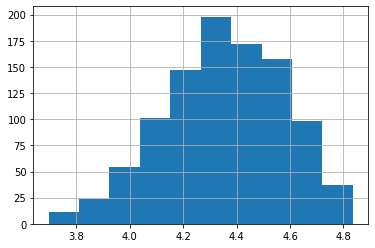

In [ ]:
tst.score.hist()

In [ ]:
print_high_low(tst)

Worst translation:
Translation: Oprócz uczynienia tego osobistym, więc będziemy rozmawiać o twoim związku z twoim sercem, a wszystkie kobiety to związek z ich sercem, będziemy wnosić w politykę.
Reference: Oprócz tego że jest to sprawa osobista porozmawiamy o waszym podejściu do serca i ogólnie o podejściu kobiet do ich serca. Porozmawiamy o polityce
Best tranlation:
Translation: Zacznijmy od obejrzenia kilku świetnych zdjęć.
Reference: Zacznijmy od obejrzenia kilku wspaniałych zdjęć.


In [ ]:
out = tst['score']

In [ ]:
out.to_csv(f'drive/MyDrive/poleval2021/nonblind_{EXPNUM}.tsv', sep='\t', index=False, header=None)

In [ ]:
# out2 = tst['score'].apply(lambda r: np.round(r, decimals=1))

In [ ]:
# out2.to_csv(f'drive/MyDrive/poleval2021/nonblind_{EXPNUM}a.tsv', sep='\t', index=False, header=None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
